In [ ]:
!pip install rasterio -q
!pip install timm -q
!pip install pytorch-lightning -q
!pip install segmentation-models-pytorch -q
!pip install wandb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00


In [ ]:
import torch
import rasterio
import numpy as np
import timm
import matplotlib.pyplot as plt

from skimage.filters import unsharp_mask
import pandas as pd
import glob
from pathlib import Path
import copy
import albumentations as A
from rasterio.plot import show
import wandb
from pytorch_lightning.loggers import WandbLogger


wandb.init(project='flood_detection', entity='amanbagrecha')
# Create a logger
logger = WandbLogger()

In [ ]:
version_number = 'v1'
feature = f'/content/drive/MyDrive/foss4g23/{version_number}'

In [ ]:
feature_dir = Path(f'{feature}/images')
label_dir = Path(f'{feature}/masks')

In [ ]:
def include_or_not(x):

  if not Path(f"{label_dir}/{x}").exists():
    return False

  if np.any(rasterio.open(f'{label_dir}/{x}').read()):

    arr_val = rasterio.open(f"{feature_dir}/{x}").read(1)
    invalid_pc = np.count_nonzero(np.isnan(arr_val))/ arr_val.size
    return invalid_pc < .1
  else:
    return False


In [ ]:
df = pd.DataFrame([Path(i).name for i in glob.glob(f"{feature_dir}/*")], columns=['chip_id'])
df['include'] = df.chip_id.apply(include_or_not)


In [ ]:
df[df.include == True].shape

(596, 2)

In [ ]:
def perform_preprocesses(arr_img, hparams, chip_id):

  # contrast stretching
  p_min, p_max = np.nanpercentile(arr_img, (1, 99), axis=(1,2),keepdims=True)
  # replace nan with 0
  # TODO: Include log transform


  arr_img = np.clip((arr_img - p_min) / (p_max - p_min + 0.01), 0, 1).astype(np.float32)

  arr_img = (arr_img).transpose((1,2,0))

  # image sharpening
  arr_img = unsharp_mask(arr_img, radius=hparams['radius_unsharp'], amount=hparams['amt_unsharp'], channel_axis=2, preserve_range=True)


  arr_img[np.isnan(arr_img)] = hparams['nafill_value']

  return arr_img

In [ ]:
class FloodDataset(torch.utils.data.Dataset):
    """Reads in images, transforms pixel values, and serves a
    dictionary containing chip ids, image tensors, and
    label masks (where available).
    """

    def __init__(self, metadata, feature_dir, hparams, label_dir=None, transforms=None ):
        self.chip_ids = metadata.chip_id.tolist()
        self.feature_dir = feature_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.hparams = hparams

    def __len__(self):
        return len(self.chip_ids)

    def __getitem__(self, idx):
        chip_id = self.chip_ids[idx]
        vv_path = self.feature_dir / chip_id
        with rasterio.open(vv_path) as vv:
            vv_img = vv.read()
            vv_img[-1, :, :] += 1


        x_arr = perform_preprocesses(vv_img, self.hparams, chip_id)

        if self.transforms:
            x_arr = self.transforms(image=x_arr)["image"]
        x_arr = np.transpose(x_arr, [2, 0, 1])

        # Prepare sample dictionary
        sample = {"chip_id": chip_id, "chip": x_arr}

        # Load label if available - training only
        if self.label_dir is not None:
            label_path = self.label_dir / chip_id
            with rasterio.open(label_path) as lp:
                y_arr = lp.read(1).astype(np.float32)
            # Apply same data augmentations to label
            if self.transforms:
                y_arr = self.transforms(image=y_arr)["image"]
            sample["label"] = y_arr

        return sample

In [ ]:
import albumentations
# These transformations will be passed to our model class
training_transformations = albumentations.Compose(
    [
        albumentations.VerticalFlip(p=0.2),
        albumentations.RandomCrop(512,512, p=0.2),
    ]
)

In [ ]:
hparams = {
    # Required hparams
    "feature_dir": feature_dir,
    "label_dir": label_dir,
    # Optional hparams
    "backbone": "resnet34",
    "weights": "imagenet",
    "in_channels": 4,
    "lr": 1e-3,
    "min_epochs": 6,
    "max_epochs": 200,
    "patience": 4,
    "batch_size": 8,
    "num_workers": 1,
    "val_sanity_checks": 0,
    "fast_dev_run": False,
    "output_path": "model_outputs",
    "log_path": "tensorboard_logs",
    "gpu": torch.cuda.is_available(),
    "transformation": training_transformations,#training_transformations
    "radius_unsharp":1,
    "amt_unsharp":1,
    "nafill_value":0
}
wandb.config.update(hparams)


In [ ]:
a_ = FloodDataset(df, feature_dir, hparams, label_dir , transforms=hparams['transformation'])

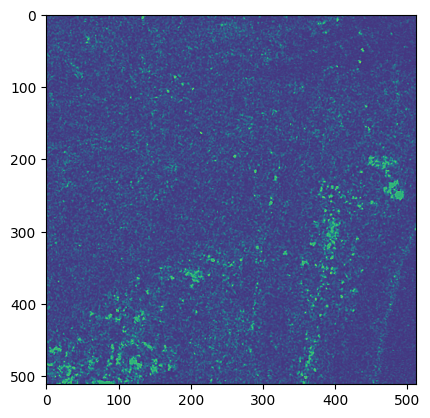

<Axes: >

In [ ]:
show(a_[630]['chip'][2,:])

In [ ]:
class XEDiceLoss(torch.nn.Module):
    """
    Computes (0.5 * CrossEntropyLoss) + (0.5 * DiceLoss).
    """

    def __init__(self):
        super().__init__()
        self.xe = torch.nn.CrossEntropyLoss(reduction="none")

    def forward(self, pred, true):
        valid_pixel_mask = true.ne(255)  # valid pixel mask

        # Cross-entropy loss
        temp_true = torch.where(~valid_pixel_mask, 0, true)
        xe_loss = self.xe(pred, temp_true)
        xe_loss = xe_loss.masked_select(valid_pixel_mask).mean()

        # Dice loss
        pred = torch.softmax(pred, dim=1)[:, 1]
        pred = pred.masked_select(valid_pixel_mask)
        true = true.masked_select(valid_pixel_mask)
        dice_loss = 1 - (2.0 * torch.sum(pred * true)) / (torch.sum(pred + true) + 1e-7)

        return (0.5 * xe_loss) + (0.5 * dice_loss)

In [ ]:
def intersection_and_union(pred, true):
    """
    Calculates intersection and union for a batch of images.

    Args:
        pred (torch.Tensor): a tensor of predictions
        true (torc.Tensor): a tensor of labels

    Returns:
        intersection (int): total intersection of pixels
        union (int): total union of pixels
    """
    valid_pixel_mask = true.ne(255)  # valid pixel mask
    true = true.masked_select(valid_pixel_mask).to("cpu")
    pred = pred.masked_select(valid_pixel_mask).to("cpu")

    # Intersection and union totals
    intersection = np.logical_and(true, pred)
    union = np.logical_or(true, pred)
    return intersection.sum(), union.sum()

In [ ]:
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

In [ ]:
class FloodModel(pl.LightningModule):
    def __init__(self, train_metadata, val_metadata, hparams):
        super().__init__()
        self.hparams.update(hparams)
        self.feature_dir = self.hparams.get("feature_dir")
        self.label_dir = self.hparams.get("label_dir")
        self.train_chip_ids = self.hparams.get("train_chip_ids")
        self.val_chip_ids = self.hparams.get("val_chip_ids")
        self.transform = self.hparams.get('transformation')
        self.backbone = self.hparams.get("backbone", "resnet34")
        self.weights = self.hparams.get("weights", "imagenet")
        self.in_channels = self.hparams.get("in_channels", 3)
        self.learning_rate = self.hparams.get("lr", 1e-3)
        self.max_epochs = self.hparams.get("max_epochs", 1000)
        self.min_epochs = self.hparams.get("min_epochs", 6)
        self.patience = self.hparams.get("patience", 4)
        self.num_workers = self.hparams.get("num_workers", 2)
        self.batch_size = self.hparams.get("batch_size", 4)
        self.fast_dev_run = self.hparams.get("fast_dev_run", False)
        self.val_sanity_checks = self.hparams.get("val_sanity_checks", 0)
        self.gpu = self.hparams.get("gpu", False)
        self.output_path = Path.cwd() / self.hparams.get("output_path", "model_outputs")
        self.output_path.mkdir(exist_ok=True)
        self.log_path = Path.cwd() / hparams.get("log_path", "tensorboard_logs")
        self.log_path.mkdir(exist_ok=True)

        # Instantiate training and val datasets
        self.train_dataset = self._build_df(train_metadata, group="train")
        self.val_dataset = self._build_df(val_metadata, group="val")

        # Instantiate model and trainer params
        self.model = self._prepare_model()
        self.trainer_params = self._get_trainer_params()
        self.save_hyperparameters()
        # Track validation IOU globally (reset each epoch)
        self.intersection = 0
        self.union = 0

    def forward(self, image):
        # Forward pass
        return self.model(image)

    def training_step(self, batch, batch_idx):
        # Switch on training mode
        self.model.train()
        torch.set_grad_enabled(True)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass
        preds = self.forward(x)
        # Calculate training loss
        criterion = XEDiceLoss()
        xe_dice_loss = criterion(preds, y)

        # Log batch xe_dice_loss
        self.log(
            "xe_dice_loss", xe_dice_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True,
        )
        preds = torch.argmax(preds, dim=1, keepdim=True)
        tp, fp, fn, tn = smp.metrics.get_stats(preds, y.long().unsqueeze(1), mode="binary")

        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")

        # print(f"{iou_score.shape=}")
        metrics_dict = {
            "train_iou_score": iou_score,
            "train_f1_score": f1_score,
            "train_f2_score": f2_score,
            "train_accuracy": accuracy,
            "train_recall": recall
        }
        # print(mydict)
        # for key, value in metrics_dict.items():
        self.log_dict(metrics_dict)

        return xe_dice_loss

    def validation_step(self, batch, batch_idx):
        # Switch on validation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass & softmax
        preds = self.forward(x)
        preds = torch.argmax(preds, dim=1, keepdim=True)

        tp, fp, fn, tn = smp.metrics.get_stats(preds, y.long().unsqueeze(1), mode="binary")

        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")

        metrics_dict = {
            "val_iou_score": iou_score,
            "val_f1_score": f1_score,
            "val_f2_score": f2_score,
            "val_accuracy": accuracy,
            "val_recall": recall
        }
        self.log_dict(metrics_dict)
        self.log(
            "iou", metrics_dict['val_iou_score'], on_step=True, on_epoch=True, prog_bar=True, logger=True
        )

        return metrics_dict['val_iou_score']

    def train_dataloader(self):
        # DataLoader class for training
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
        )

    def val_dataloader(self):
        # DataLoader class for validation
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=0,
            shuffle=False,
            pin_memory=True,
        )

    def configure_optimizers(self):
        # Define optimizer
        optimizer = torch.optim.Adam(
            self.model.parameters(), lr=self.learning_rate
        )
        # Define scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="max", factor=0.5, patience=self.patience
        )
        scheduler = {
            "scheduler": scheduler, "interval": "epoch", "monitor": "iou_epoch",
        }  # logged value to monitor
        return [optimizer], [scheduler]

    def on_validation_epoch_end(self):
        # Reset metrics before next epoch
        self.intersection = 0
        self.union = 0


    ## Convenience Methods ##


    def _build_df(self, metadata, group):
        # Instantiate datasets
        if group == "train":
            df = FloodDataset(
                    metadata=metadata,
                    feature_dir=self.feature_dir,
                    hparams=self.hparams,
                    label_dir=self.label_dir,
                    transforms=self.transform

            )
        elif group == "val":
            df = FloodDataset(
                    metadata=metadata,
                    feature_dir=self.feature_dir,
                    hparams=self.hparams,
                    label_dir=self.label_dir,
                    transforms=None
            )
        return df

    def _prepare_model(self):
        # Instantiate U-Net model

        unet_model = smp.Unet(
            encoder_name=self.backbone,
            encoder_weights=self.weights,
            in_channels=self.in_channels,
            classes=2,
        )
        if self.gpu:
            unet_model.cuda()
        return unet_model

    def _get_trainer_params(self):
        # Define callback behavior
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=self.output_path,
            monitor="iou_epoch",
            mode="max",
            verbose=True,
        )
        # Define early stopping behavior
        early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
            monitor="iou_epoch",
            patience=(self.patience * 3),
            mode="max",
            verbose=True,
        )
        # Specify where TensorBoard logs will be saved
        logger = pl.loggers.TensorBoardLogger(self.log_path, name="benchmark-model")
        trainer_params = {
            "callbacks": [checkpoint_callback, early_stop_callback],
            "max_epochs": self.max_epochs,
            "min_epochs": self.min_epochs,
            "default_root_dir": self.output_path,
            "log_every_n_steps": 1,
            "logger": logger,
            # "gpus": None if not self.gpu else 1,
            "fast_dev_run": self.fast_dev_run,
            "num_sanity_val_steps": self.val_sanity_checks,
        }
        return trainer_params

    def fit(self):
        # Set up and fit Trainer object
        self.trainer = pl.Trainer(**self.trainer_params)
        self.trainer.fit(self)

In [ ]:
metadata = df[df.include]

In [ ]:
df_ = pd.DataFrame(np.random.randn(*metadata.shape))

msk = np.random.rand(len(df_)) < 0.8
train_metadata = metadata[msk]
validation_metadata = metadata[~msk]

In [ ]:
validation_metadata.shape

(119, 2)

In [ ]:
flood_model = FloodModel(train_metadata=train_metadata, val_metadata=validation_metadata, hparams=hparams)

In [ ]:
flood_model.fit()

In [ ]:
flood_model.trainer_params["callbacks"][0].best_model_score

tensor(0.6551, device='cuda:0')

In [ ]:
submission_path = Path("benchmark-pytorch")
submission_path.mkdir(exist_ok=True)
submission_assets_path = submission_path / "assets"
submission_assets_path.mkdir(exist_ok=True)

In [ ]:
weight_path = submission_assets_path / "flood_model.pt"
torch.save(flood_model.state_dict(), weight_path)

### Inference

In [ ]:
import numpy as np
import pytorch_lightning as pl
import rasterio
import segmentation_models_pytorch as smp
import torch


class FloodModel(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.model = smp.Unet(
            encoder_name="resnet34",
            encoder_weights=None,
            in_channels=4,
            classes=2,
        )
        self._hparams = hparams

    def forward(self, image):
        # Forward pass
        return self.model(image)

    def predict(self, vv_path):
        # Switch on evaluation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Create a 2-channel image
        with rasterio.open(vv_path) as vv:
            x_arr = vv.read()#[[0,1,3],:]
            x_arr[-1,:] += 1

        x_arr = perform_preprocesses(x_arr, self._hparams,vv_path)
        x_arr = x_arr.transpose((2,0,1))

        x_arr = np.expand_dims(x_arr, axis=0)

        # Perform inference
        preds = self.forward(torch.from_numpy(x_arr))
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1
        return preds.detach().numpy().squeeze().squeeze()

In [ ]:
def make_prediction(chip_id, model):
    """
    Given a chip_id, read in the vv/vh bands and predict a water mask.

    Args:
        chip_id (str): test chip id

    Returns:
        output_prediction (arr): prediction as a numpy array
    """
    try:
        vv_path = feature_dir / chip_id
        output_prediction = model.predict(vv_path)
    except Exception as e:
        raise
    return output_prediction

In [ ]:
model = FloodModel(hparams)
model.load_state_dict(torch.load(Path('/content/benchmark-pytorch/assets/flood_model.pt' )) )

<All keys matched successfully>

In [ ]:
validation_metadata

,chip_id,include
6,6.tif,True
7,7.tif,True
19,22.tif,True
29,19.tif,True
30,33.tif,True
...,...,...
742,874.tif,True
744,876.tif,True
756,890.tif,True
762,877.tif,True


<Axes: >

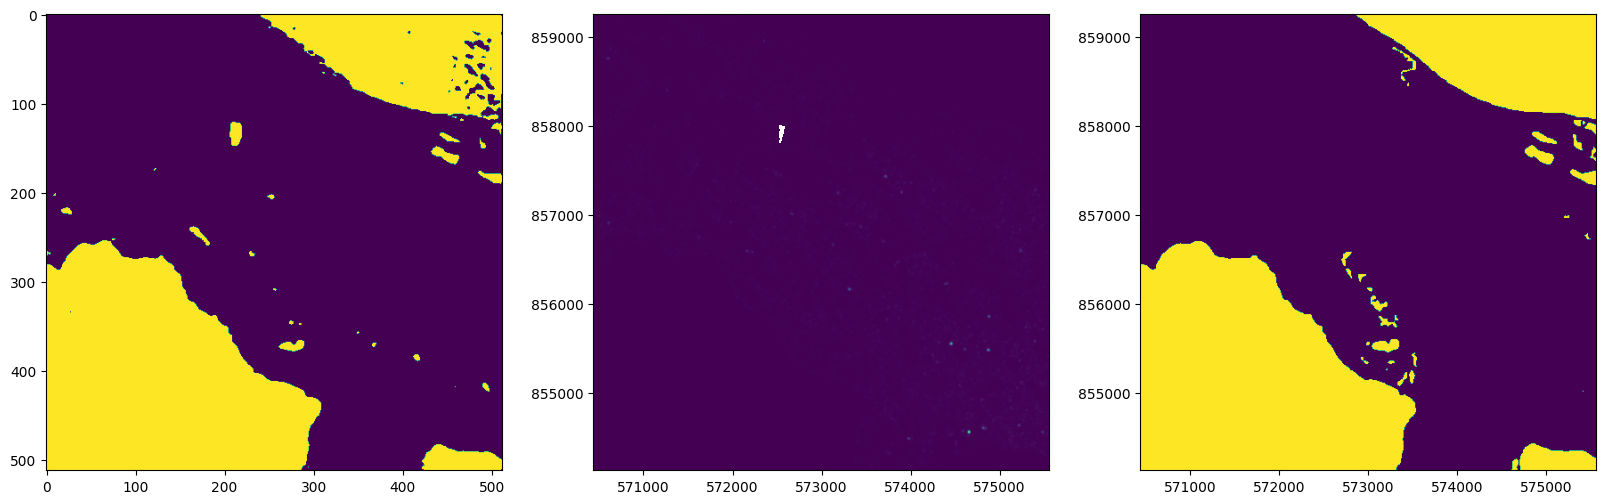

In [ ]:
import matplotlib.pyplot as plt
from rasterio.plot import show

no_ = 400
fig, ax = plt.subplots(1,3, figsize= (20,20))
a =make_prediction(Path(f'{no_}.tif'), model)
b = rasterio.open(f'/content/drive/MyDrive/foss4g23/{version_number}/images/{no_}.tif')
c = rasterio.open(f'/content/drive/MyDrive/foss4g23/{version_number}/masks/{no_}.tif')

show(a, ax=ax[0])
show(b, ax=ax[1])
show(c, ax=ax[2])